In [1]:
import sys
import pandas as pd
import re
import os
import math
import gzip
import matplotlib.pyplot as plt
import numpy as np

def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    pred['Dex.refScore'] = np.exp(pred['Dex.refScore'])
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp
    

In [2]:
# get predicted reference score by models which were trained by simulated sequences
# python /datacommons/igvf-pm/K562/leave-one-out/BlueSTARR/test-variants-fc.py /datacommons/igvf-pm/A549/GR-AP1/simulated-seq/slurm/DMSO-200-log /datacommons/igvf-pm/A549/GR-AP1/simulated-seq/slurm/Dex-200-log /datacommons/igvf-pm/A549/GR-AP1/simulated-seq/low-activation/low_act_5000_installed.txt /datacommons/igvf-pm/A549/GR-AP1/simulated-seq/low-activation/low_act_5000_installed_FC.txt

fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_FC.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'DMSO.refScore', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,DMSO.refScore,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,3.492868,3.485808,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,4.377771,4.377890,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,3.753764,3.747371,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,4.359409,4.349590,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,3.241862,3.230929,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...,...
4995,chr1:119611950-119612250,2.625609,2.601749,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,3.269436,3.254540,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,4.349829,4.326254,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,2.787088,2.833086,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


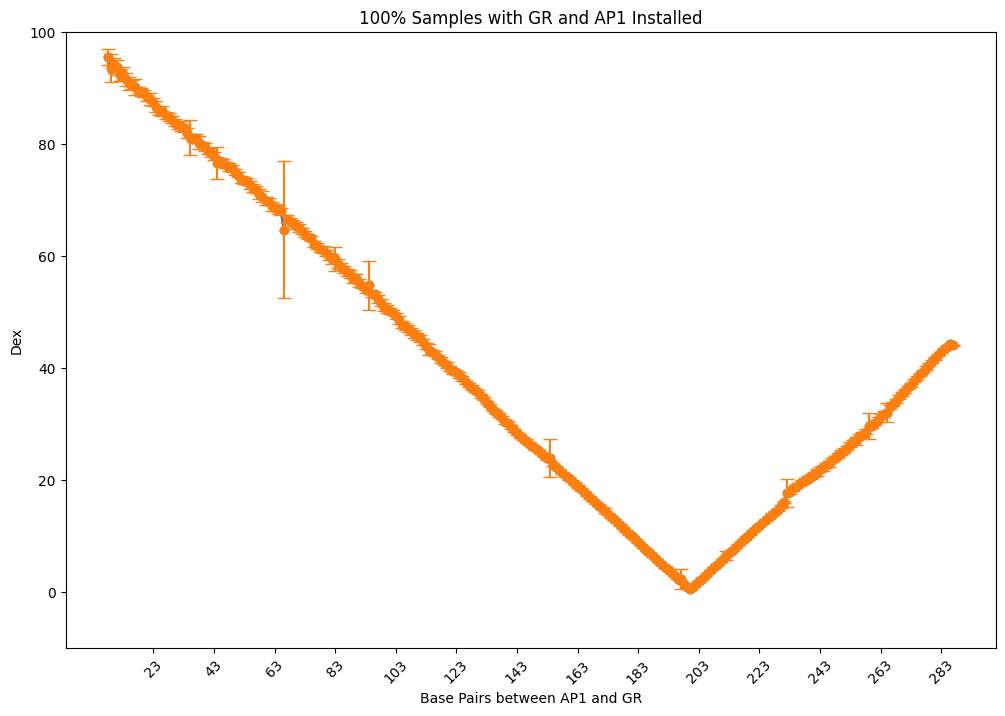

In [3]:
df_tmp = fc_dist
df_tmp['fc'] = np.exp(df_tmp['Dex.refScore']) # convert to normal scale since model was trained on log scale
# df_tmp = df_tmp.loc[df_tmp['distance'].isin(np.arange(23, 284, 20)), ]

df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("100% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(-10,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [4]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/diluting/low_act_5000_test_FC_0.9.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,22.645157,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,78.874460,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,29.337576,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,75.957760,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,22.958115,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...
4995,chr1:119611950-119612250,21.536427,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,23.339012,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,68.618980,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,15.382772,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


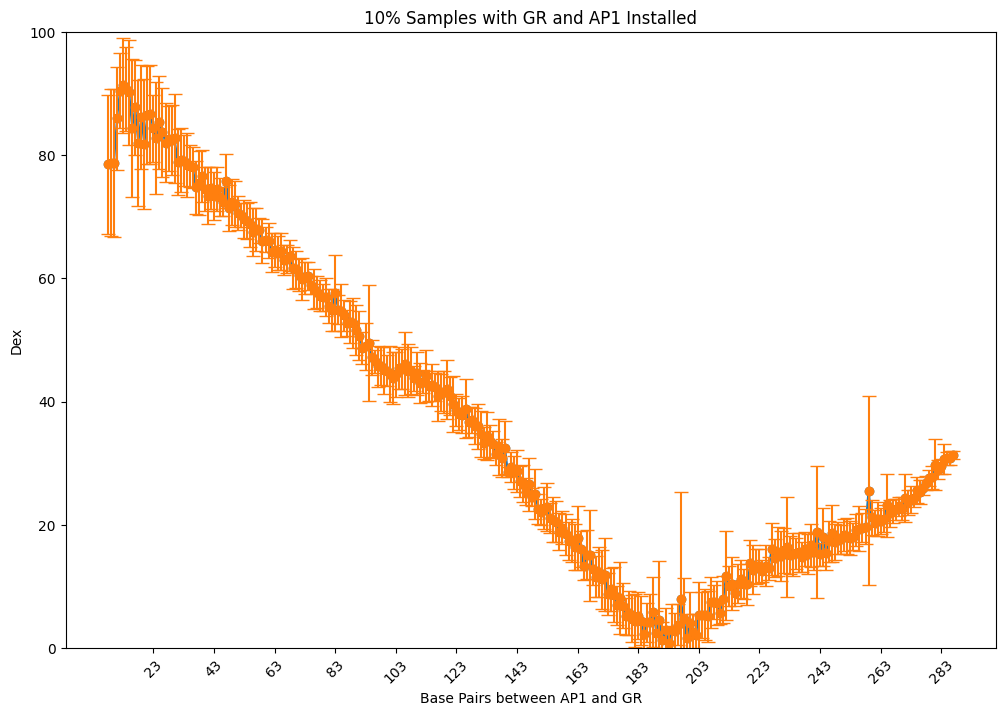

In [5]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("10% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [6]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/diluting/low_act_5000_test_FC_0.95.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,7.353279,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,37.470880,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,9.629049,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,33.674984,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,9.140606,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...
4995,chr1:119611950-119612250,9.451120,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,10.157963,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,34.290432,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,5.056630,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


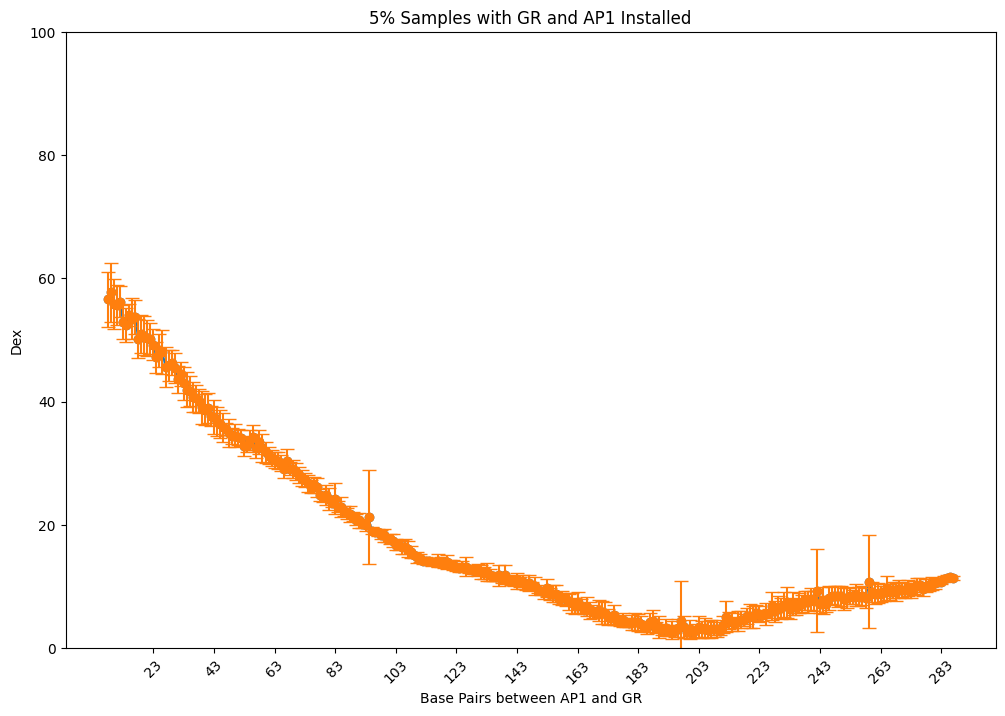

In [7]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("5% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [2]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/diluting/low_act_5000_test_FC_0.98.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,14.064170,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,49.045803,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,19.058966,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,46.862885,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,16.348558,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...
4995,chr1:119611950-119612250,15.361314,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,16.483742,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,46.434920,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,6.900169,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


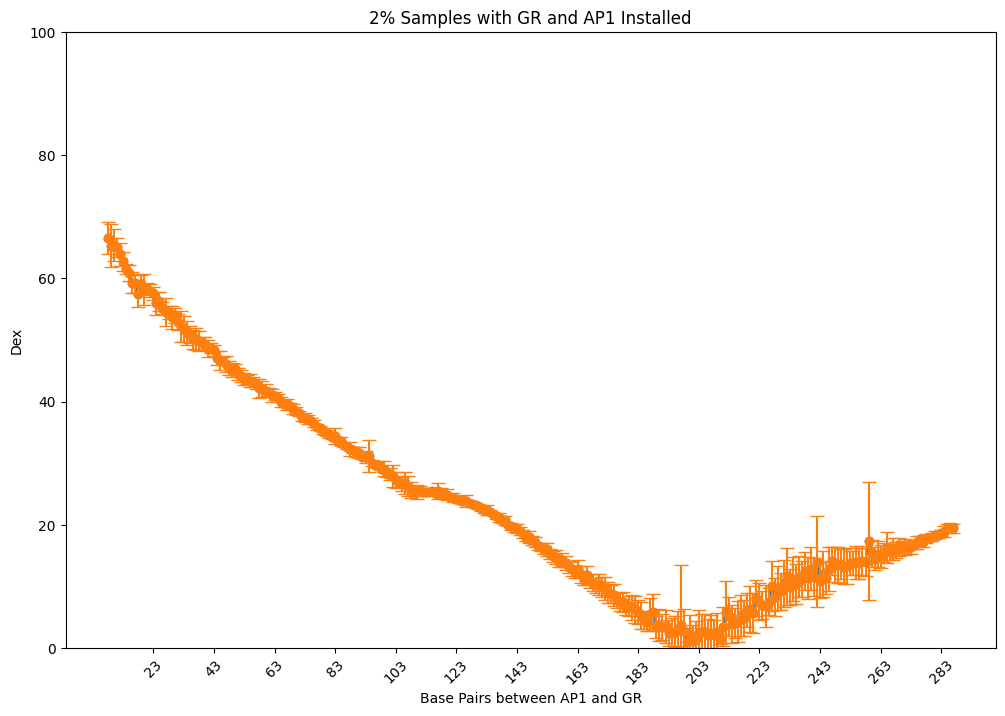

In [4]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("2% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [5]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/diluting/low_act_5000_test_FC_0.98_2.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,11.230061,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,48.656414,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,13.788952,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,46.852020,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,13.573708,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...
4995,chr1:119611950-119612250,10.489534,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,17.920082,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,43.916843,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,9.268689,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


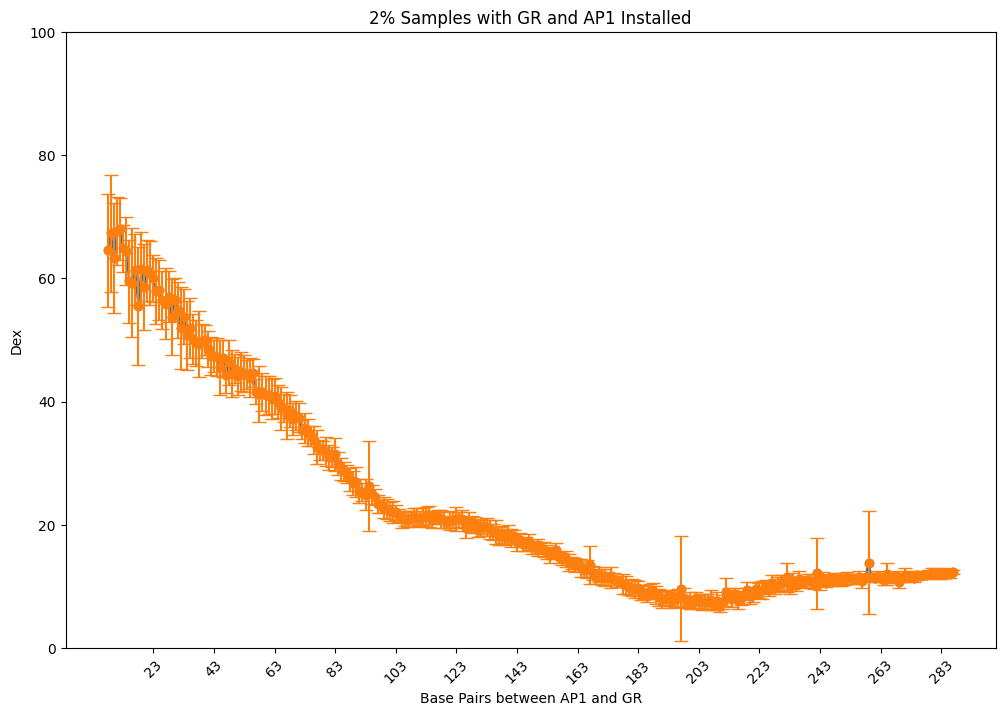

In [6]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("2% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [8]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/diluting/low_act_5000_test_FC_0.99.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr9:134226700-134227000,1.362599,GTTGAGTCATCAGTGACCTCCCGCCCGCCTGGTGATAGACCCTTGG...,266
1,chr12:108459350-108459650,1.347620,CTCTAAGTTTAGAAACAGATTTTGCTCCAACCCTGCAGGGGCATGT...,39
2,chr11:87703150-87703450,1.104313,TTGAGTCATTTCCAGTTTTTCTGCTCTGTTTTTTCCCCAAGTTTGT...,282
3,chr20:31348900-31349200,1.344826,AAGCTGACTGAAGAGCACTTGCGCTTTGCGTGAACATCAGCAGTAG...,44
4,chr7:112361200-112361500,1.377294,ATTAGAAATTAAGCAACCTGTAAGAATGTACAATGAGTCATAACAA...,150
...,...,...,...,...
4995,chr1:119611950-119612250,1.374289,TATATGAGTACTGAGAATGGAGCTGAGCCGAAGTCACTGGGAAAAG...,227
4996,chr2:109190900-109191200,1.178076,AGAGTATTGTGATACTTTGCCTACTAGATGCCAATATTTTTATGTG...,149
4997,chr18:21551300-21551600,1.343023,TCTACTAAAAATACAAAAAATTAGCCAGGCGTAGTGGCGGCACCTG...,46
4998,chr6:3470800-3471100,1.436309,TTCTTCTGAGTCATTACTTTCAAACGCCACTCCTTTTGATGTTGGC...,232


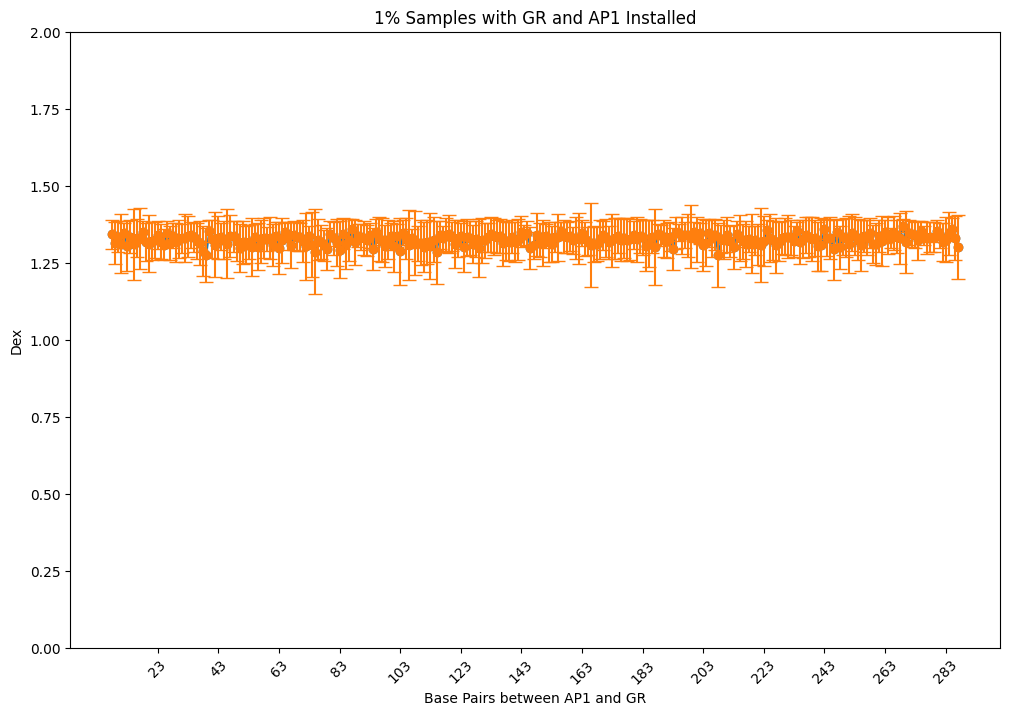

In [11]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("1% Samples with GR and AP1 Installed")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,2)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [4]:
# 1% positive samples before biased downsampling, 3% positive samples after biased downsampling
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_pred.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
fc_dist

,location,Dex.refScore,sequence,distance
0,chr22:10723400-10723700,0.323323,CATTCCATTCCATTCCATTAAATTCCATTCTGAGTCATTCCATTCC...,201
1,chr22:11435650-11435950,98.153275,GGTGGGGCTCCTGCCTGCCAATTTAGAAGGGGTGGGGCTCCCACCT...,10
2,chr22:17104800-17105100,87.749490,GACACTCCAGGTAGGGGACATGCGGCTGTCCTAGGCCATACTGGGA...,28
3,chr22:17591750-17592050,8.971013,ACCCGGGAGGCTGAGTCATCAGTGAGCCGAGATGGCACCACTGCAC...,183
4,chr22:18131200-18131500,54.152042,GAGAACAGAACACTCTCCCCGCCCCAGCCTGATTCCTGCCTTACCC...,95
...,...,...,...,...
4995,chr1:242519700-242520000,34.956550,TGAGTCATGAGCAAGCAAGGGCCCCACTAGCCAAGAAGAGTCAGGC...,272
4996,chr1:242754400-242754700,26.522385,ATGTCAGAAAGTGCCTGGAAGTAGGGAGTGGTCTAAAGAATTTGCT...,149
4997,chr1:242882150-242882450,82.023820,GCCTGCTCTGAGAAGACACCATGCAGCGTCTTCGTGTCTTGGGCCA...,37
4998,chr1:245894050-245894350,39.780030,TCTGAGTCATTGAAGCCAGCTGGACTTCCAGGGTGGAGTGGGGAAT...,282


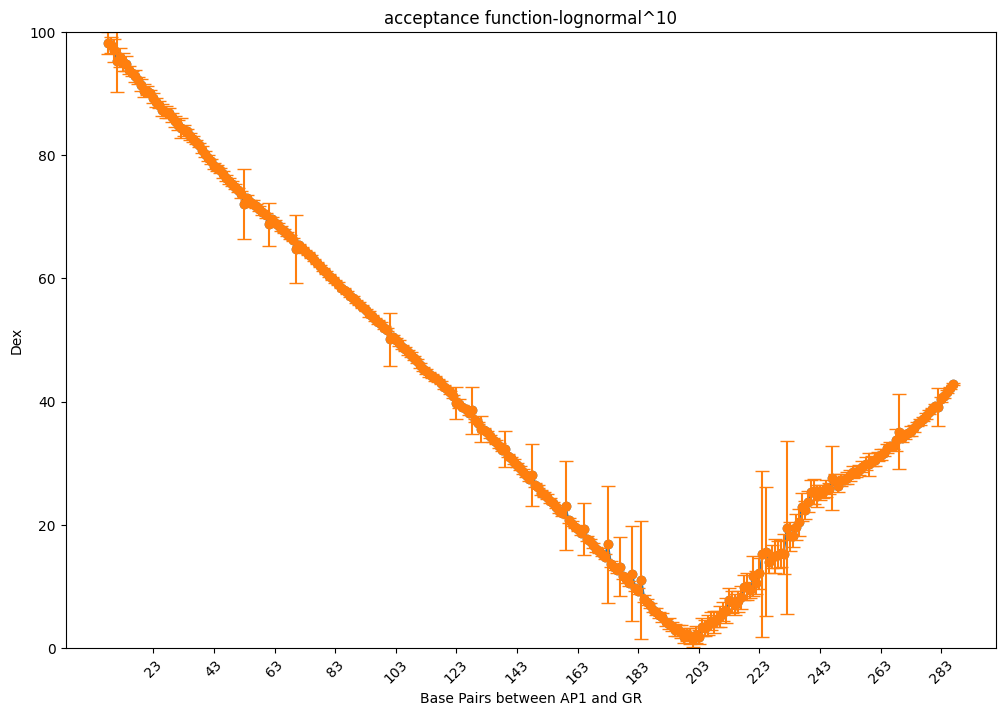

In [8]:
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("acceptance function-lognormal^10")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

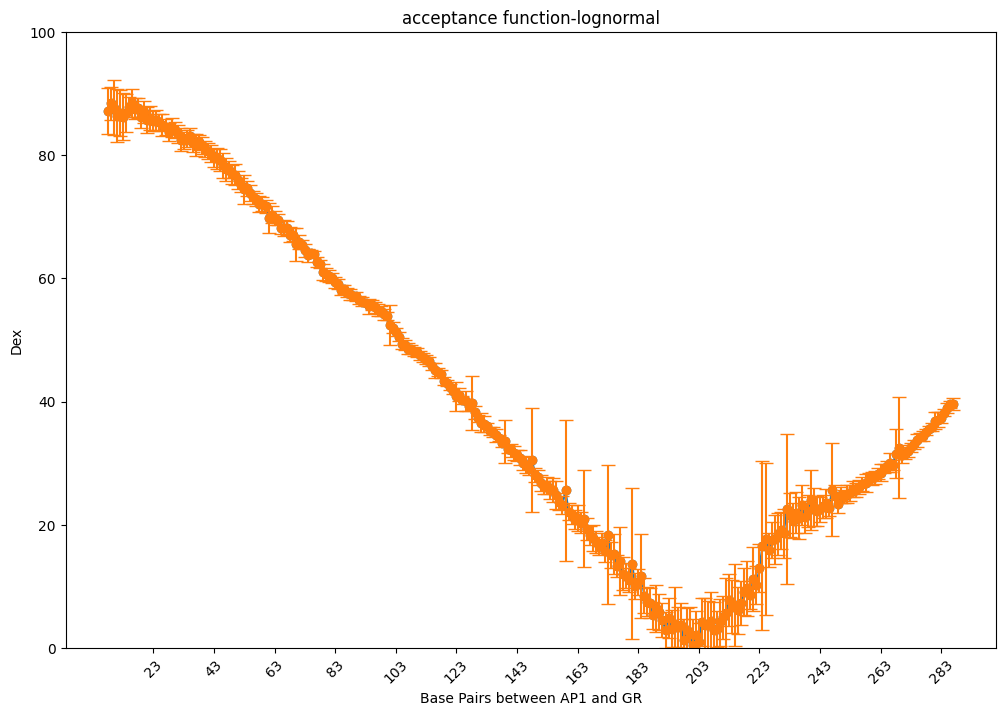

In [9]:
fc = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_pred_lognormal.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fc.columns = ['location', 'Dex.refScore', 'sequence']
loc_dist.columns = ['location','distance']
fc_dist = pd.merge(fc, loc_dist, how='inner', on='location')
df_tmp = fc_dist
df_tmp['fc'] = df_tmp['Dex.refScore']
df_tmp = df_tmp.groupby('distance').agg(mean_fc=('fc', 'mean'), sd_fc=('fc', 'std')).reset_index()

plt.figure(figsize=(12, 8))
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o')
plt.title("acceptance function-lognormal")
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Dex")
plt.ylim(0,100)
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5)
plt.xticks(np.arange(23, 284, 20), rotation=45)
plt.show()

In [2]:
def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp

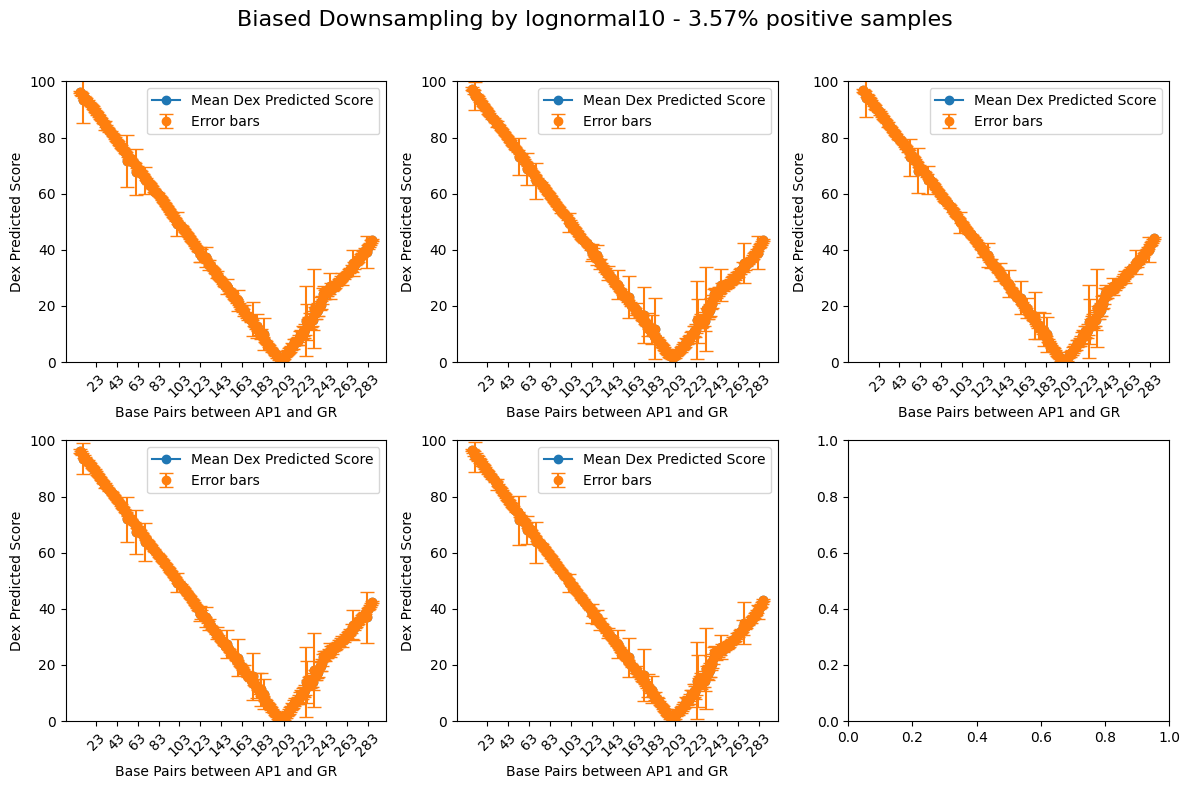

In [3]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Biased Downsampling by lognormal10 - 3.57% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.01-positive/low_act_5000_test_pred_lognormal10_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

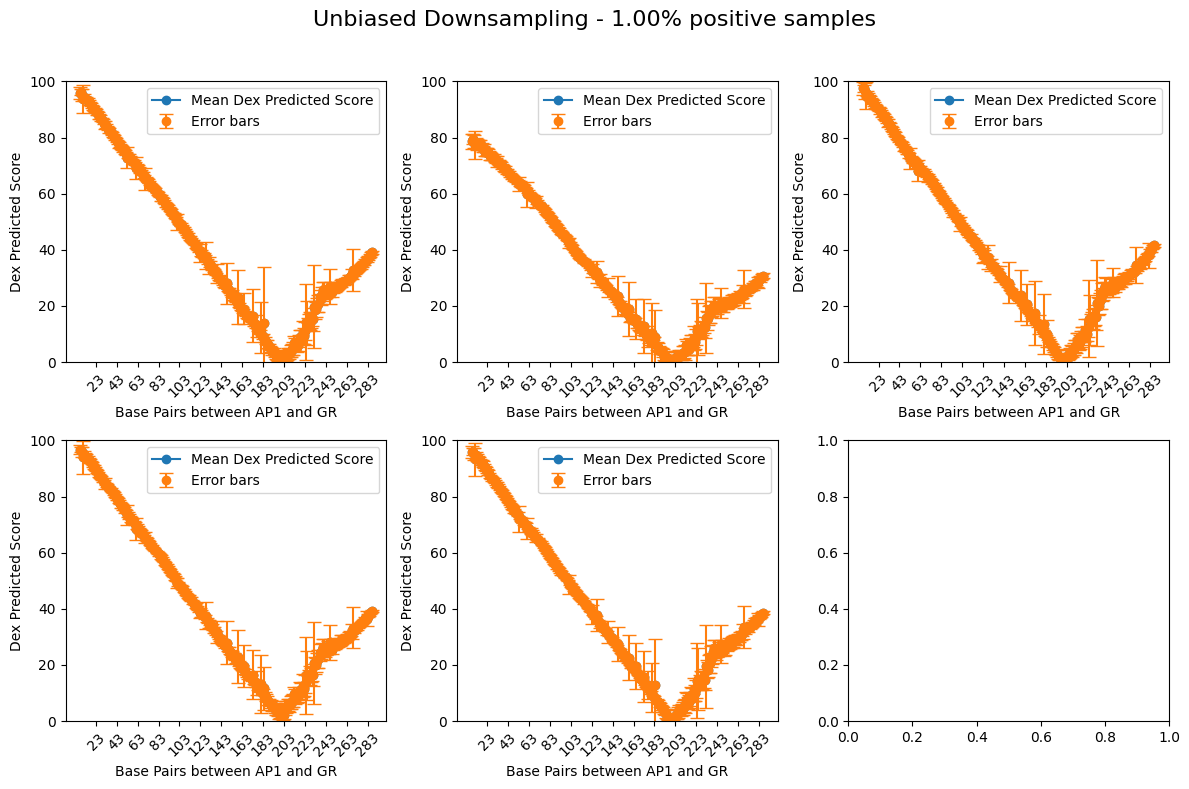

In [4]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Unbiased Downsampling - 1.00% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.01-positive/low_act_5000_test_pred_unbiased_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

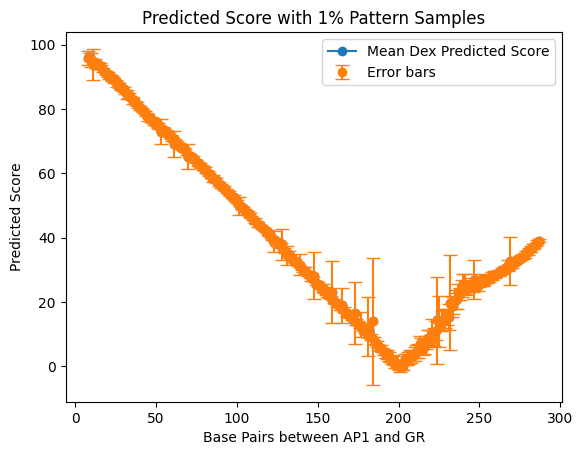

In [9]:
pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.01-positive/low_act_5000_test_pred_unbiased_'+str(0+1)+'.txt', sep='\t', header=None)
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_test_dist.txt', sep='\t',header=None)
df_tmp = plots(pred, loc_dist) 
plt.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
plt.xlabel("Base Pairs between AP1 and GR")
plt.ylabel("Predicted Score")
plt.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
plt.title('Predicted Score with 1% Pattern Samples')
plt.legend()

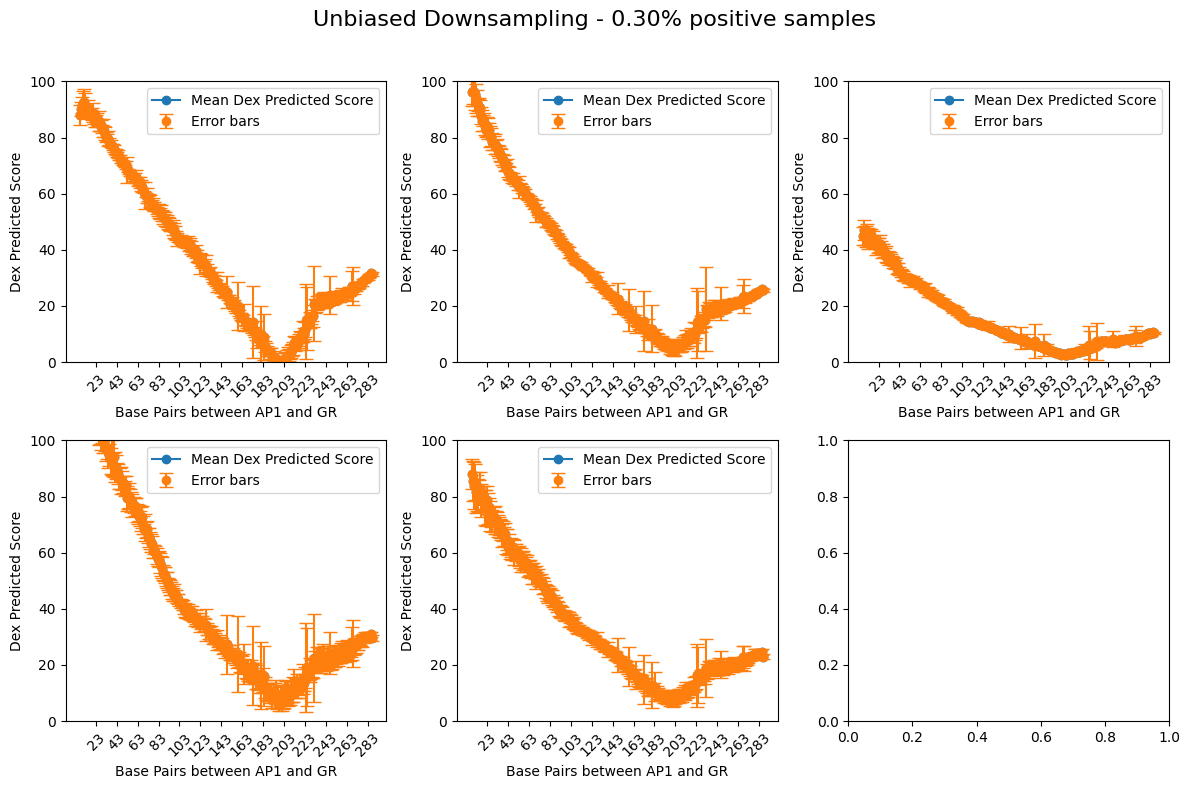

In [5]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Unbiased Downsampling - 0.30% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.003-positive/low_act_5000_test_pred_unbiased_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

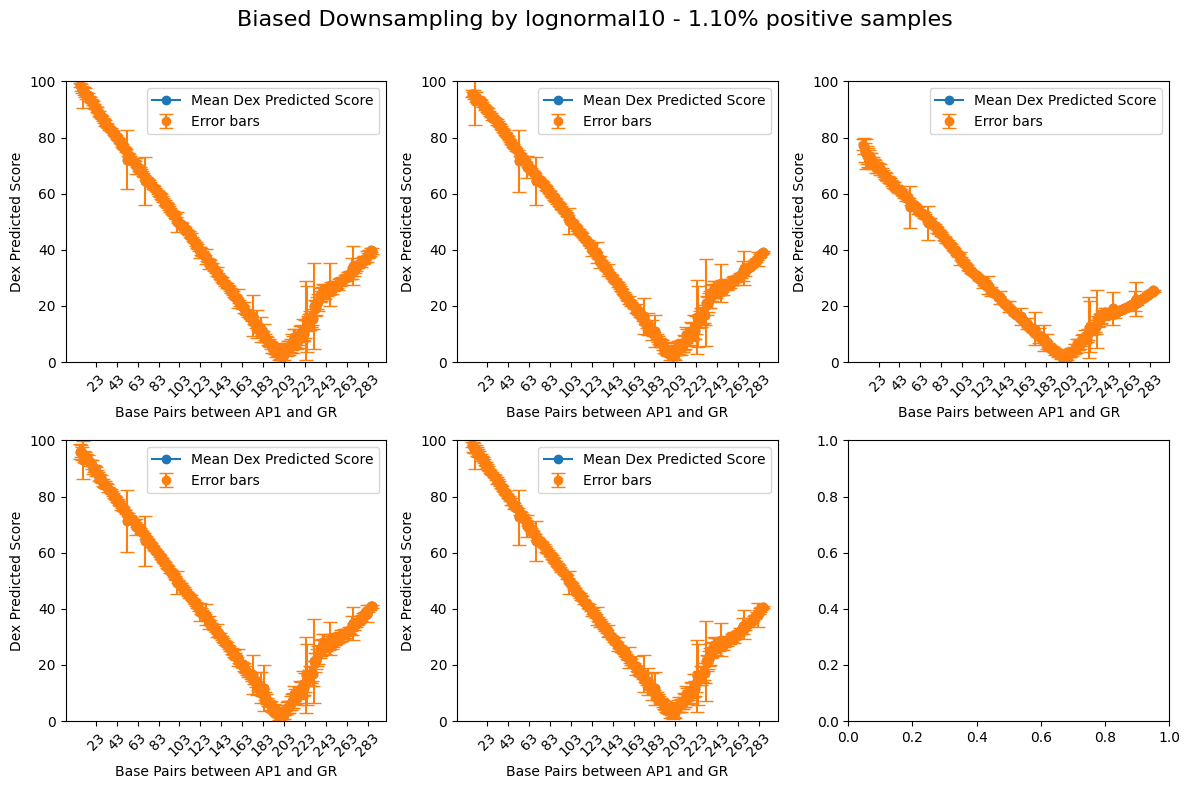

In [6]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Biased Downsampling by lognormal10 - 1.10% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.003-positive/low_act_5000_test_pred_lognormal10_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

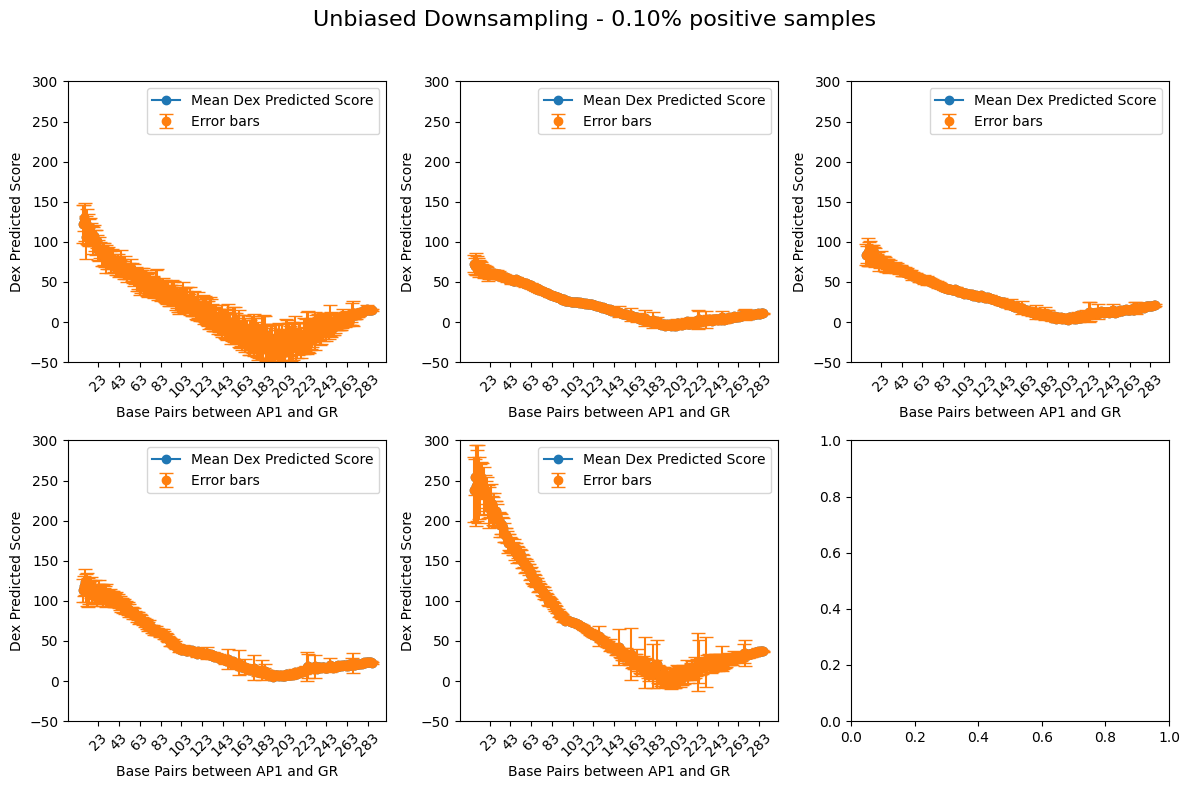

In [3]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Unbiased Downsampling - 0.10% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.001-positive/low_act_5000_test_pred_unbiased_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(-50, 300)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

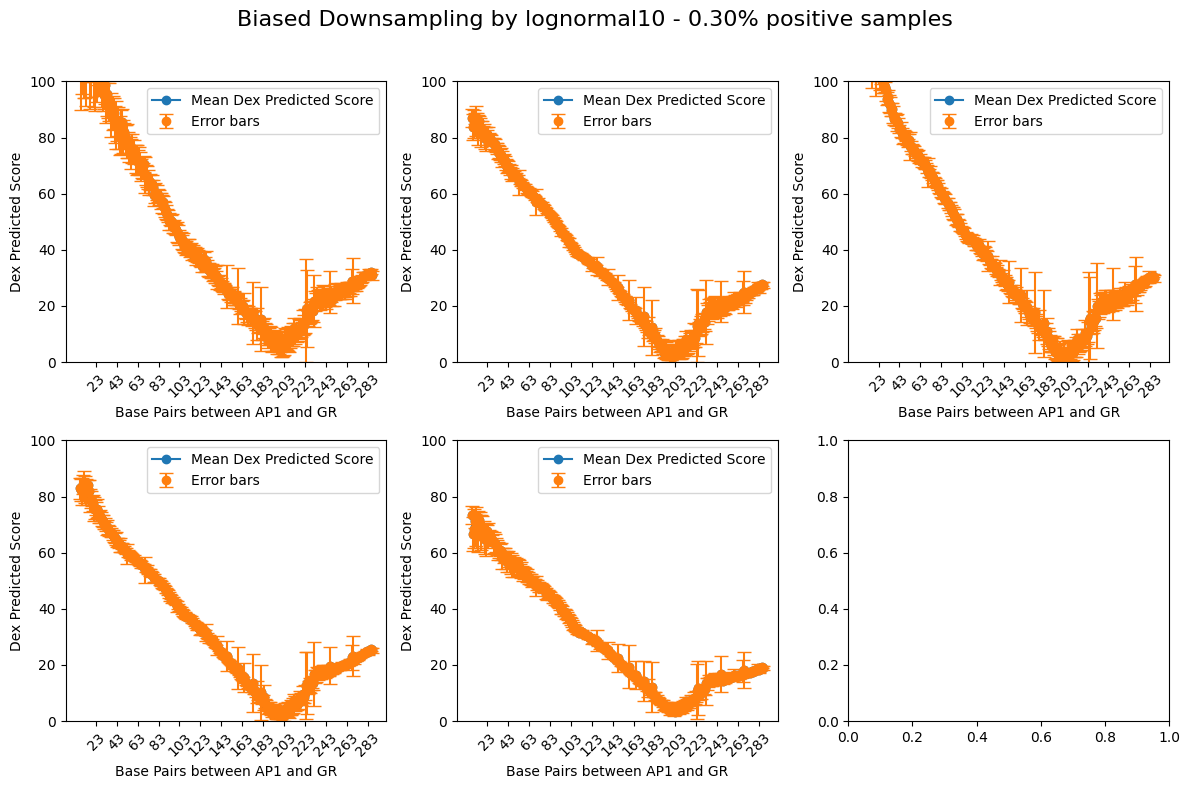

In [4]:
# unbiased vs biased sampling (acceptance function: lognormal10)
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200-biased/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Biased Downsampling by lognormal10 - 0.30% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/0.001-positive/low_act_5000_test_pred_lognormal10_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

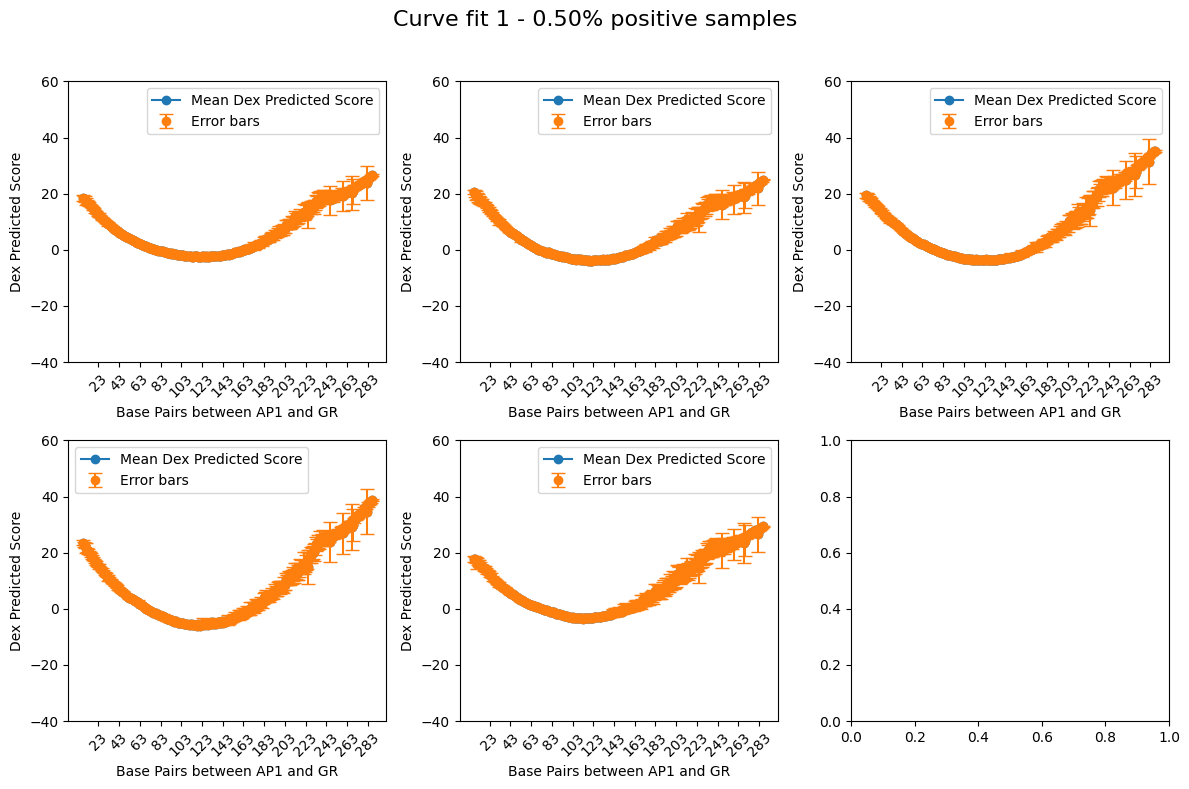

In [4]:
# curve fit by experimental data
# curve fit 1: one U-shape
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Curve fit 1 - 0.50% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/exp-fit-1/low_act_5000_test_pred_unbiased_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(-40, 60)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

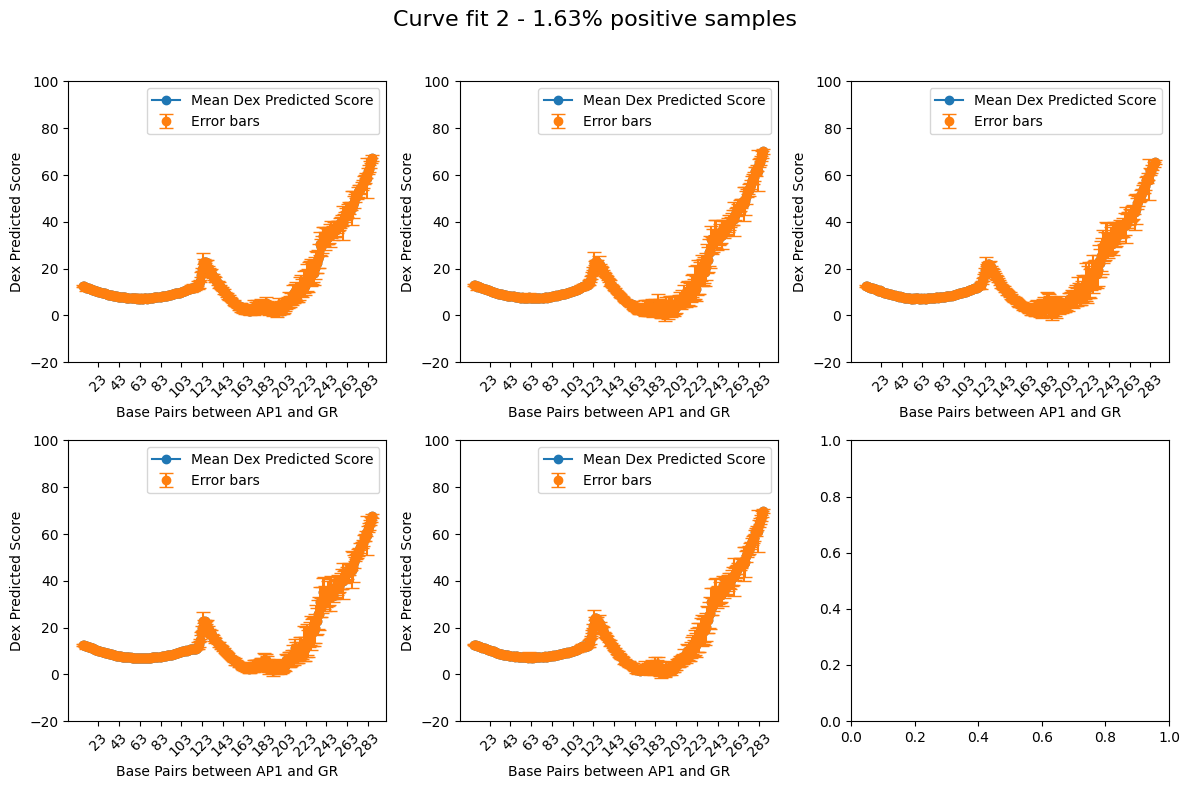

In [9]:
# curve fit by experimental data
# curve fit 2: two U-shape
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Curve fit 2 - 1.63% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/exp-fit-2/low_act_5000_test_pred_lognormal_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(-20, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

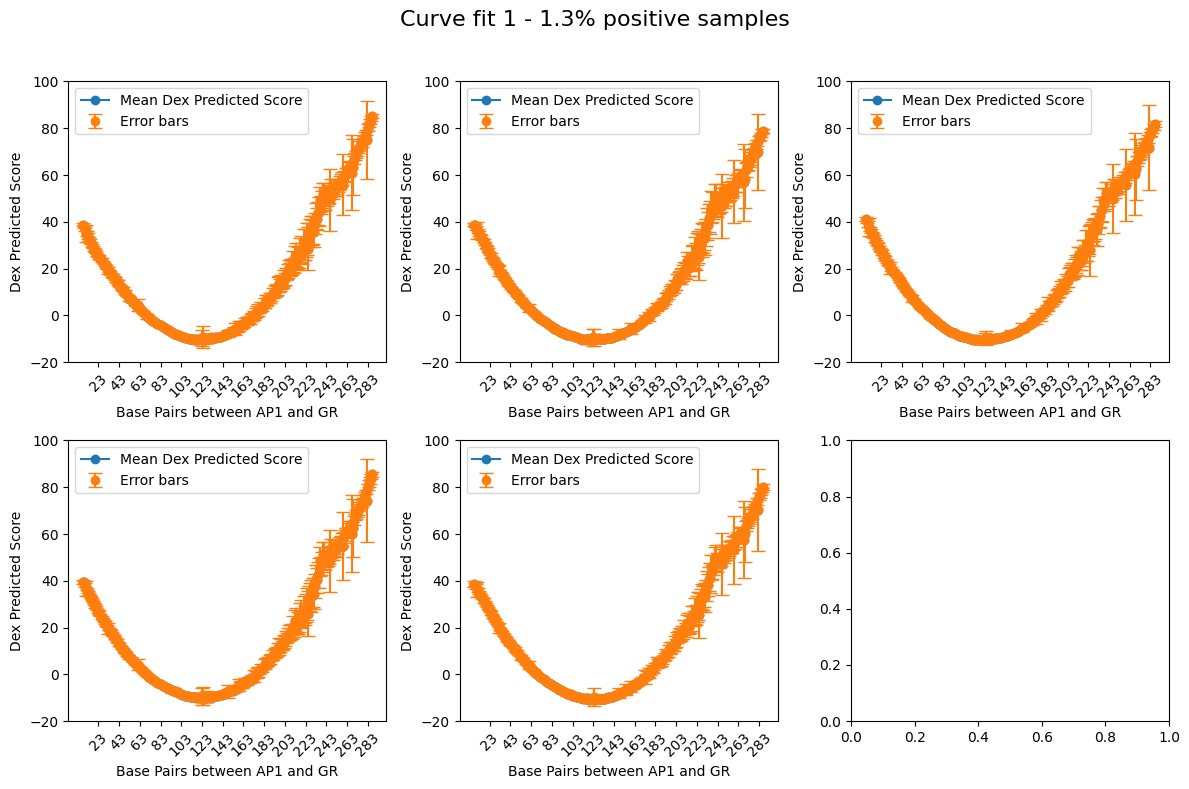

In [3]:
# curve fit by experimental data

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_test_dist.txt', sep='\t',header=None)
fig.suptitle("Curve fit 1 - 1.3% positive samples", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/datacommons/igvf-pm/A549/GR-AP1/simulated-seq/data/exp-fit-1/low_act_5000_test_pred_bluestarr_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(-20, 100)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

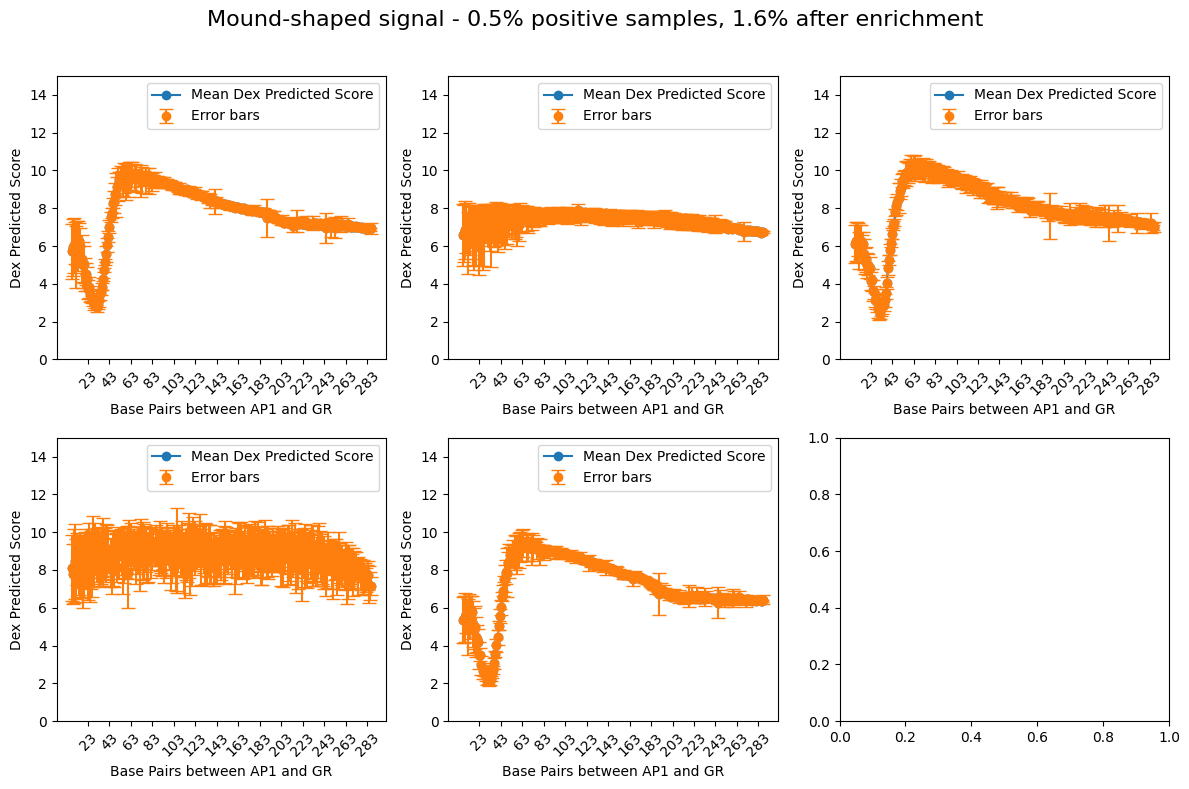

In [12]:
# mound activation shape
def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    pred['Dex.refScore'] = np.exp(pred['Dex.refScore'])
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp
    
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t',header=None)
fig.suptitle("Mound-shaped signal - 0.5% positive samples, 1.6% after enrichment", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/mound/low_act_5000_installed_pred_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 15)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

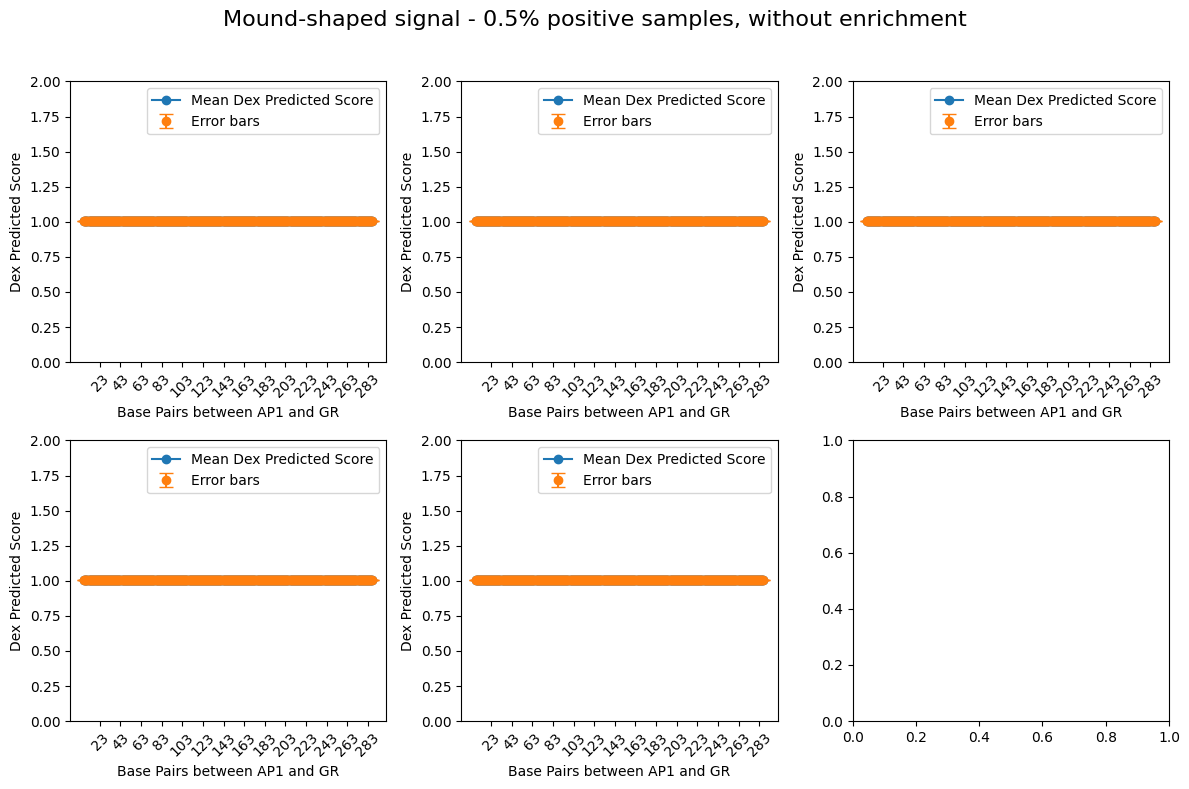

In [4]:
# mound activation shape
def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    pred['Dex.refScore'] = np.exp(pred['Dex.refScore'])
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp
    
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t',header=None)
fig.suptitle("Mound-shaped signal - 0.5% positive samples, without enrichment", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/mound/no_enrichment_0.5/pred/low_act_5000_installed_pred_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 2)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

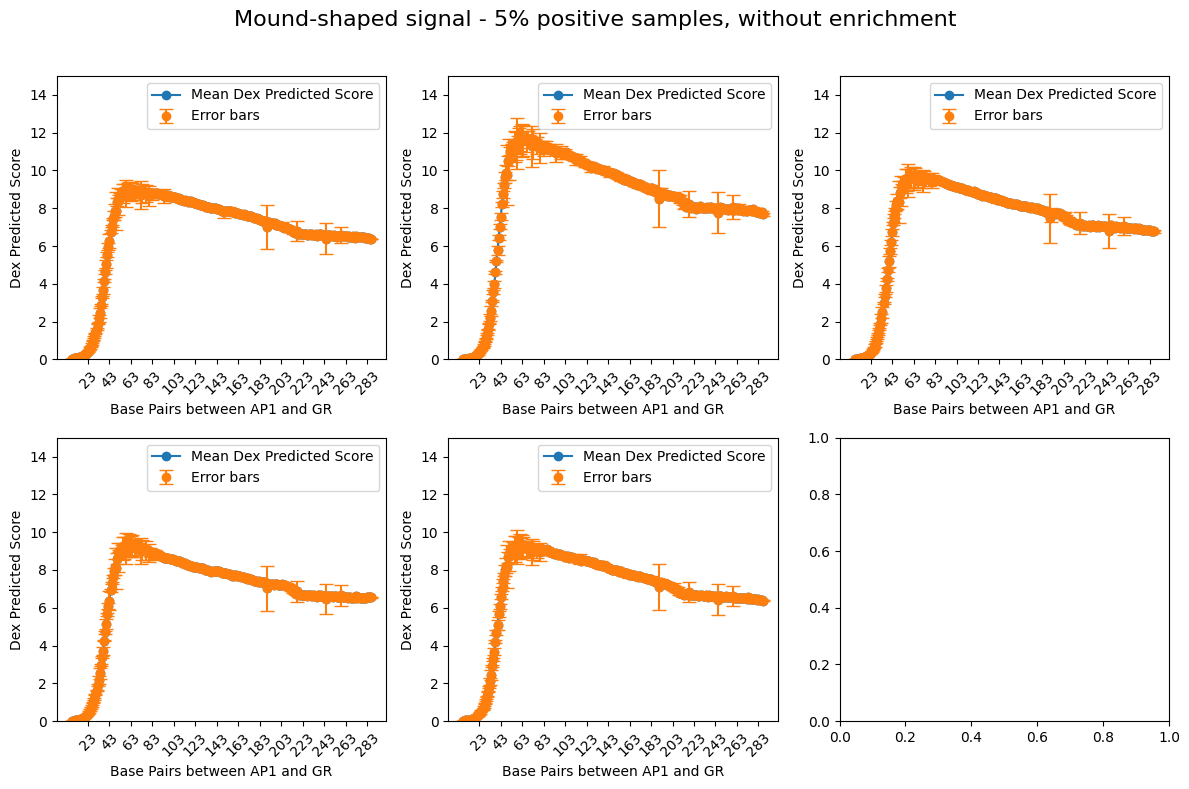

In [5]:
# mound activation shape
def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    pred['Dex.refScore'] = np.exp(pred['Dex.refScore'])
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp
    
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t',header=None)
fig.suptitle("Mound-shaped signal - 5% positive samples, without enrichment", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/mound/no_enrichment_5/pred/low_act_5000_installed_pred_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(0, 15)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])

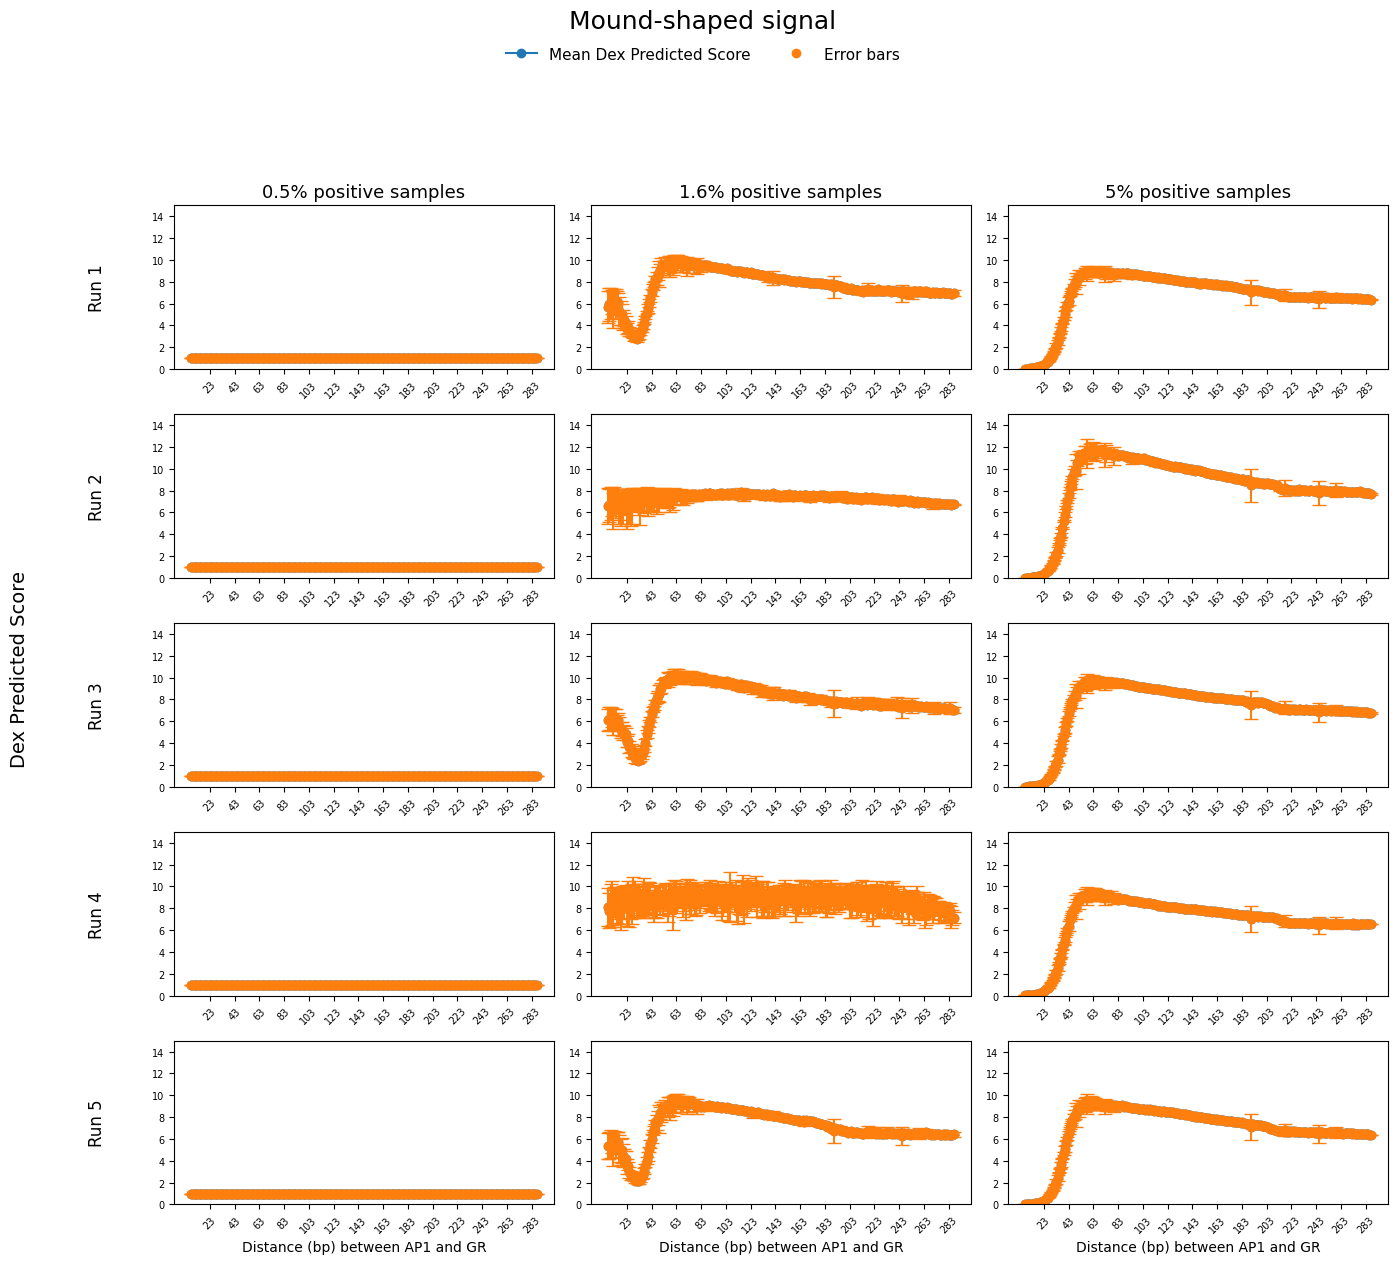

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(5, 3, figsize=(14, 12))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t', header=None)

# Column titles
col_titles = ['0.5% positive samples', '1.6% positive samples', '5% positive samples']

# Row titles
row_titles = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5']

fig.suptitle("Mound-shaped signal", fontsize=18, y=1.05)

handles, labels = [], []

for i, ax in enumerate(axes.flat):
    row_idx = i // 3
    col_idx = i % 3

    # Load corresponding prediction file
    if col_idx == 0:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/mound/no_enrichment_0.5/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    elif col_idx == 1:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/mound/enrichment_lognorm10_1.6/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    else:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/mound/no_enrichment_5/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)

    df_tmp = plots(pred, loc_dist)  # Your function to process and plot

    l1, = ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    l2 = ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')

    ax.set_ylim(0, 15)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(labelsize=7)

    # Column titles
    if row_idx == 0:
        ax.set_title(col_titles[col_idx], fontsize=13)

    # Row labels
    if col_idx == 0:
        ax.annotate(row_titles[row_idx], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    # X-axis label ONLY for bottom row
    if row_idx == 4:
        ax.set_xlabel("Distance (bp) between AP1 and GR", fontsize=10)

    if not handles:
        handles.extend([l1, l2[0]])
        labels.extend(['Mean Dex Predicted Score', 'Error bars'])

# Common y-axis label
fig.text(0.005, 0.5, 'Dex Predicted Score', va='center', rotation='vertical', fontsize=14)

# Common legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, fontsize=11, frameon=False)

# Adjust layout
fig.tight_layout(rect=[0.05, 0, 1, 0.95])

plt.show()

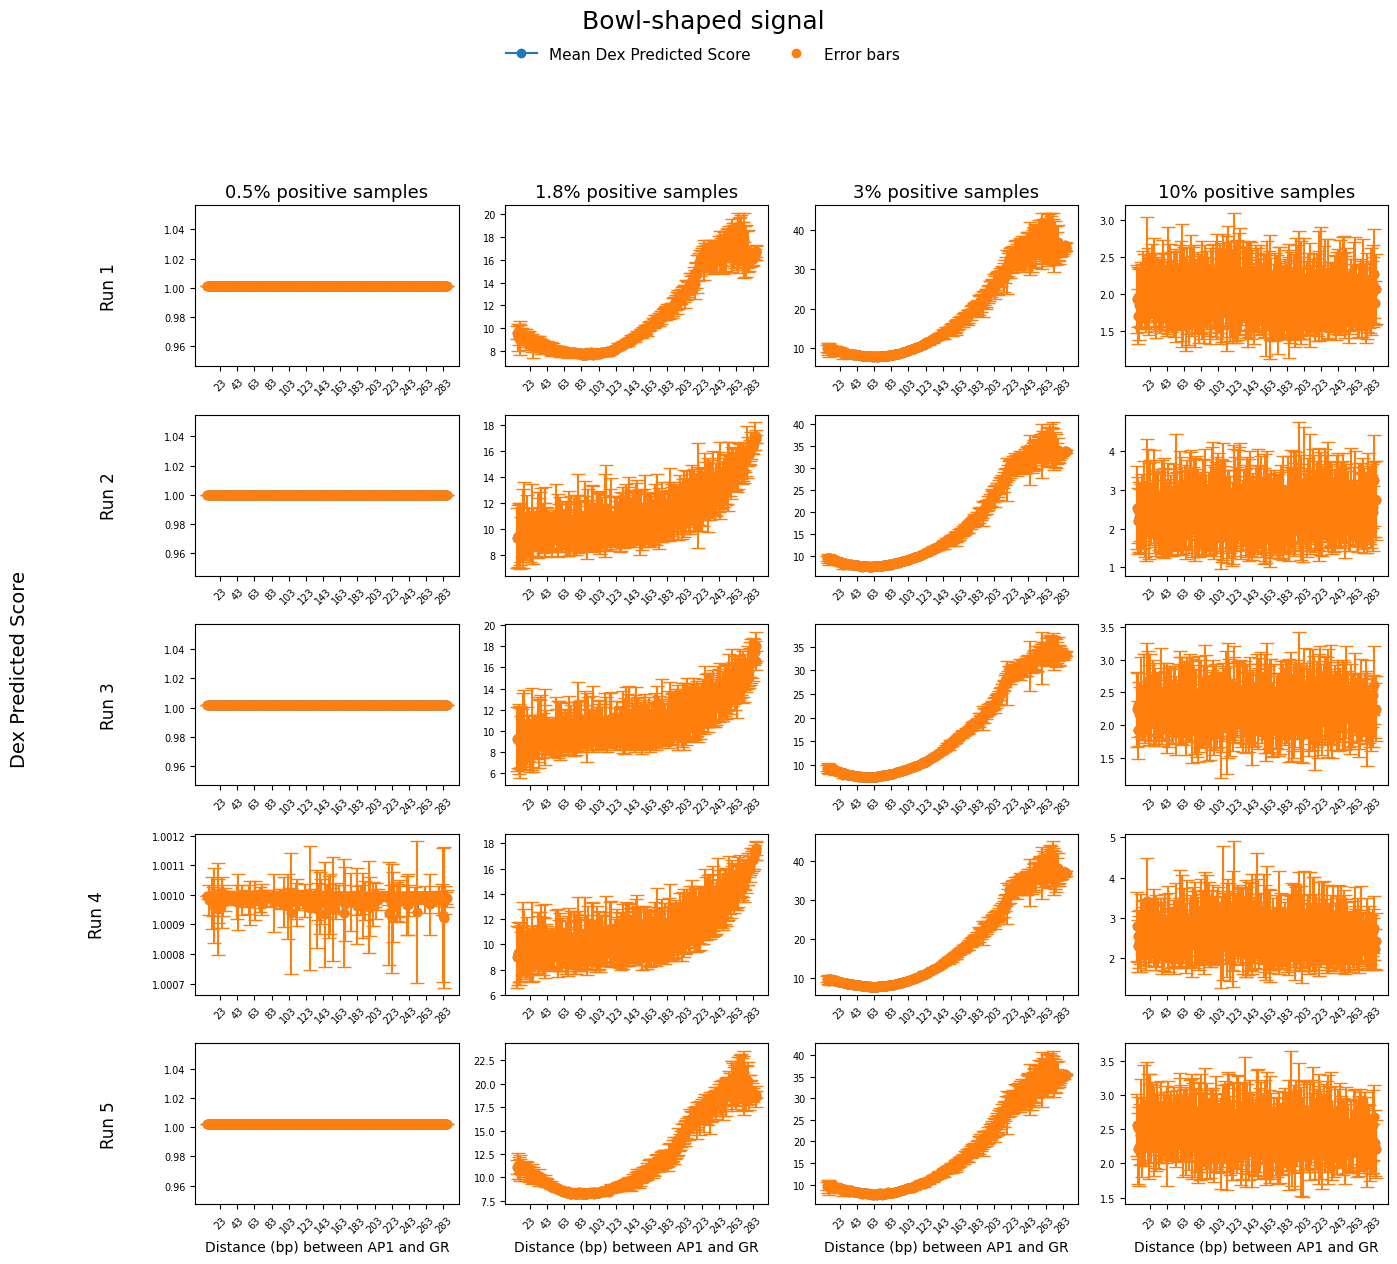

In [8]:
n = 4
fig, axes = plt.subplots(5, n, figsize=(14, 12))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t', header=None)


# Column titles
col_titles = ['0.5% positive samples', '1.8% positive samples', '3% positive samples', '10% positive samples'] # , '10% positive samples'
assert len(col_titles) == n

# Row titles
row_titles = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5']

fig.suptitle("Bowl-shaped signal", fontsize=18, y=1.05)

handles, labels = [], []

for i, ax in enumerate(axes.flat):
    row_idx = i // n
    col_idx = i % n

    # Load corresponding prediction file
    if col_idx == 0:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/bowl/no_enrichment_0.5/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    elif col_idx == 1:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/bowl/enrichment_lognormal10_1.8/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    elif col_idx == 2:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/bowl/no_enrichment_3/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    else:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/bowl/no_enrichment_10/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)

    df_tmp = plots(pred, loc_dist)  # Your function to process and plot

    l1, = ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    l2 = ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')

    # ax.set_ylim(0, 15)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(labelsize=7)

    # Column titles
    if row_idx == 0:
        ax.set_title(col_titles[col_idx], fontsize=13)

    # Row labels
    if col_idx == 0:
        ax.annotate(row_titles[row_idx], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    # X-axis label ONLY for bottom row
    if row_idx == 4:
        ax.set_xlabel("Distance (bp) between AP1 and GR", fontsize=10)

    if not handles:
        handles.extend([l1, l2[0]])
        labels.extend(['Mean Dex Predicted Score', 'Error bars'])

# Common y-axis label
fig.text(0.005, 0.5, 'Dex Predicted Score', va='center', rotation='vertical', fontsize=14)

# Common legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, fontsize=11, frameon=False)

# Adjust layout
fig.tight_layout(rect=[0.05, 0, 1, 0.95])

plt.show()

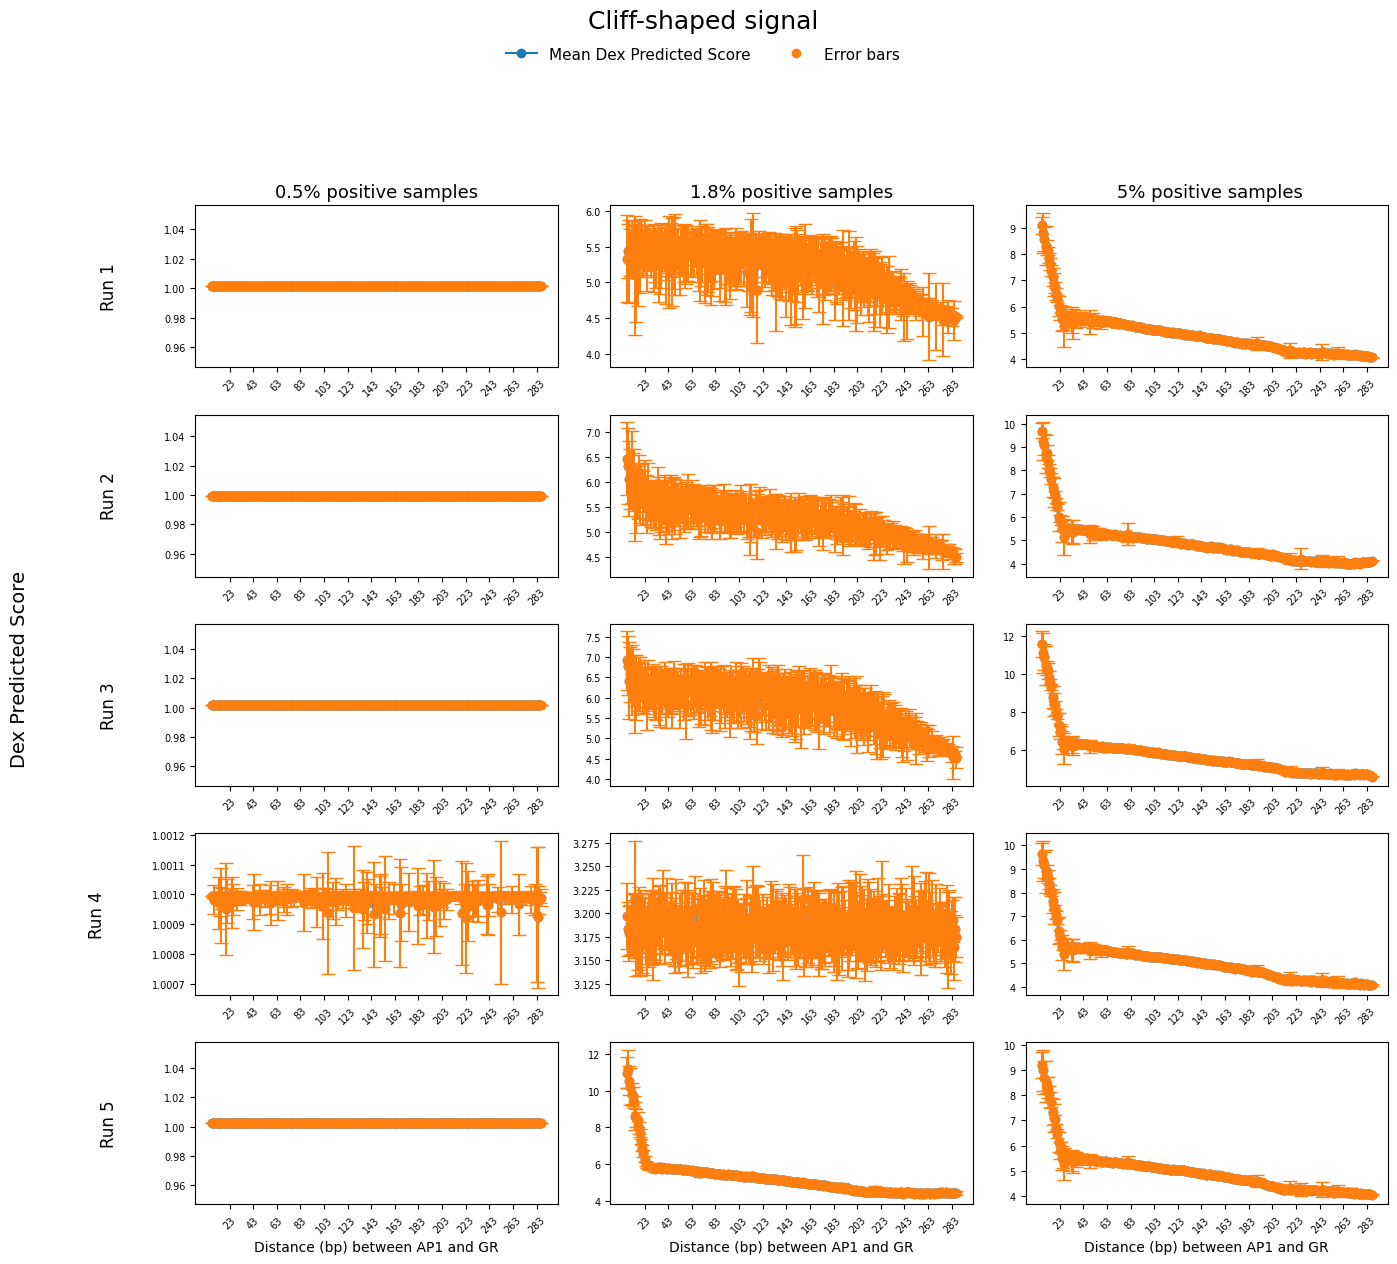

In [3]:
n = 3
fig, axes = plt.subplots(5, n, figsize=(14, 12))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t', header=None)


# Column titles
col_titles = ['0.5% positive samples', '1.8% positive samples',' 5% positive samples'] 
assert len(col_titles) == n

# Row titles
row_titles = ['Run 1', 'Run 2', 'Run 3', 'Run 4', 'Run 5']

fig.suptitle("Cliff-shaped signal", fontsize=18, y=1.05)

handles, labels = [], []

for i, ax in enumerate(axes.flat):
    row_idx = i // n
    col_idx = i % n

    # Load corresponding prediction file
    if col_idx == 0:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/bowl/no_enrichment_0.5/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    elif col_idx == 1:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/cliff/enrichment_lognormal10_1.8/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)
    elif col_idx == 2:
        pred = pd.read_csv(f'/hpc/group/igvf/A549/GR-AP1/simulated-seq/slurm/cliff/no_enrichment_5/pred/low_act_5000_installed_pred_{row_idx+1}.txt', sep='\t', header=None)

    df_tmp = plots(pred, loc_dist)  # Your function to process and plot

    l1, = ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    l2 = ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')

    # ax.set_ylim(0, 15)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(labelsize=7)

    # Column titles
    if row_idx == 0:
        ax.set_title(col_titles[col_idx], fontsize=13)

    # Row labels
    if col_idx == 0:
        ax.annotate(row_titles[row_idx], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 25, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    # X-axis label ONLY for bottom row
    if row_idx == 4:
        ax.set_xlabel("Distance (bp) between AP1 and GR", fontsize=10)

    if not handles:
        handles.extend([l1, l2[0]])
        labels.extend(['Mean Dex Predicted Score', 'Error bars'])

# Common y-axis label
fig.text(0.005, 0.5, 'Dex Predicted Score', va='center', rotation='vertical', fontsize=14)

# Common legend
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, fontsize=11, frameon=False)

# Adjust layout
fig.tight_layout(rect=[0.05, 0, 1, 0.95])

plt.show()

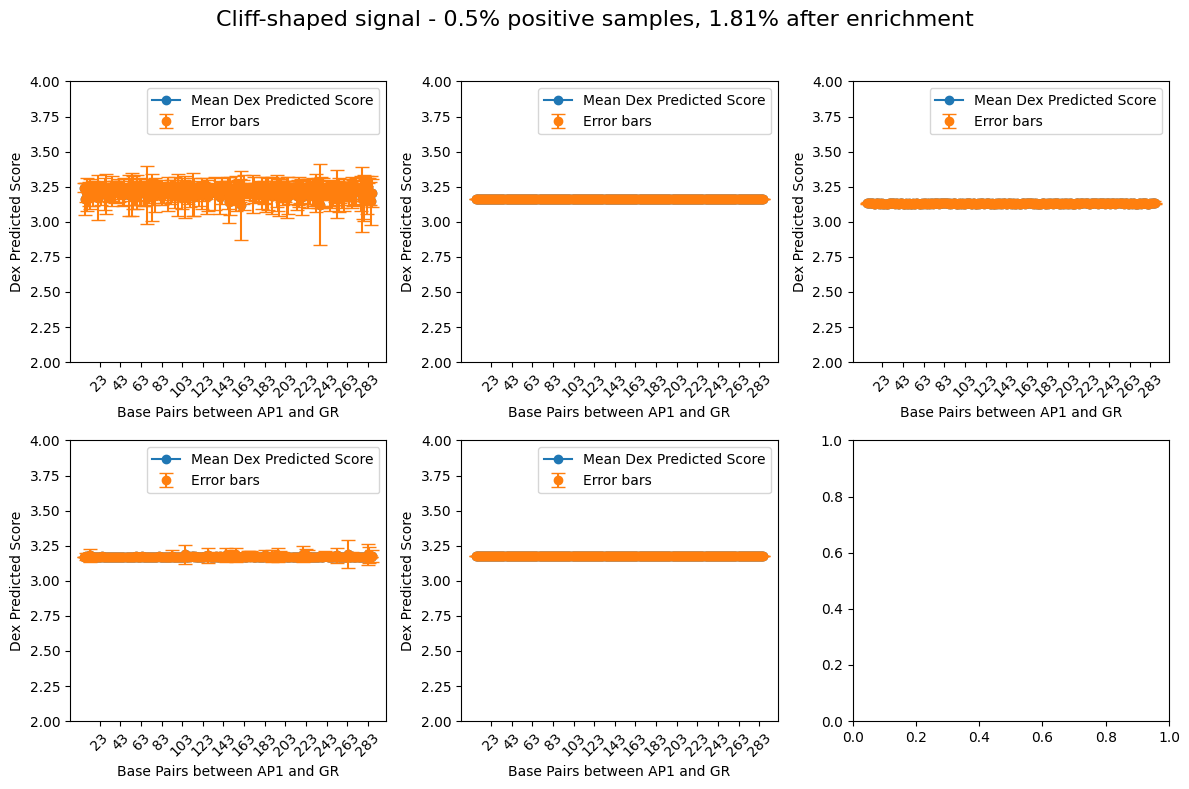

In [6]:
# mound activation shape
def plots(pred, loc_dist):
    pred.columns = ['location', 'Dex.refScore', 'sequence']
    pred['Dex.refScore'] = np.exp(pred['Dex.refScore'])
    loc_dist.columns = ['location','distance']
    pred_dist = pd.merge(pred, loc_dist, how='inner', on='location')
    df_tmp = pred_dist
    df_tmp['pred'] = df_tmp['Dex.refScore']
    df_tmp = df_tmp.groupby('distance').agg(mean_fc=('pred', 'mean'), sd_fc=('pred', 'std')).reset_index()
    return df_tmp
    
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
loc_dist = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/Dex-200/low_act_5000_installed_dist.txt', sep='\t',header=None)
fig.suptitle("Cliff-shaped signal - 0.5% positive samples, 1.81% after enrichment", fontsize=16)
for i, ax in enumerate(axes.flat):
    if i == 5: break
    pred = pd.read_csv('/hpc/group/igvf/A549/GR-AP1/simulated-seq/data/cliff/low_act_5000_installed_pred_'+str(i+1)+'.txt', sep='\t', header=None)
    df_tmp = plots(pred, loc_dist) 
    ax.plot(df_tmp['distance'], df_tmp['mean_fc'], marker='o', label='Mean Dex Predicted Score')
    ax.errorbar(df_tmp['distance'], df_tmp['mean_fc'], yerr=df_tmp['sd_fc'], fmt='o', capsize=5, label='Error bars')
    ax.set_xlabel("Base Pairs between AP1 and GR")
    ax.set_ylabel("Dex Predicted Score")
    ax.set_ylim(2, 4)
    ax.set_xticks(np.arange(23, 284, 20))
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
fig.tight_layout(rect=[0, 0, 1, 0.96])